In [2]:
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import pandas as pd

import random

from sklearn.linear_model import LinearRegression

from NeuralGraph import NeuralGraph

In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
def split_dataset(x, y, valid_split=.2, test_split=.2):
    classes = np.unique(y)
    train_valid_split = round(len(classes)*(1-(valid_split+test_split)))
    valid_test_split = round(len(classes)*(1-test_split))

    train_classes = set(classes[:train_valid_split])
    valid_classes = set(classes[train_valid_split:valid_test_split])
    test_classes = set(classes[valid_test_split:])

    train = {i:[] for i in train_classes}
    valid = {i:[] for i in valid_classes}
    test = {i:[] for i in test_classes}

    for data, class_ in zip(x, y):
        if class_ in train_classes:
            train[class_].append(data)
        
        elif class_ in valid_classes:
            valid[class_].append(data)

        else:
            test[class_].append(data)

    for class_ in train_classes:
        train[class_] = np.stack(train[class_])

    for class_ in valid_classes:
        valid[class_] = np.stack(valid[class_])

    for class_ in test_classes:
        test[class_] = np.stack(test[class_])

    return train, valid, test

In [4]:
SIZE = 14

(x, y), (_, _) = tf.keras.datasets.mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, mnist_valid, mnist_test = split_dataset(x, y, valid_split=.5, test_split=.5)

(x, y), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, fashion_valid, fashion_test = split_dataset(x, y, valid_split=.5, test_split=.5)

emnist = pd.read_csv("emnist-letters-train.csv").values
x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

emnist_train, emnist_valid, emnist_test = split_dataset(x, y)

In [5]:
train = [emnist_train]
valid = [mnist_valid, fashion_valid, emnist_valid]

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


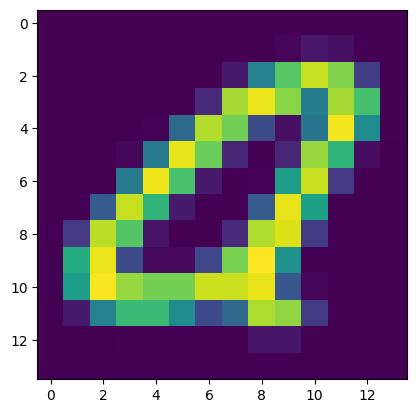

dict_keys([0, 1, 2, 3, 4])


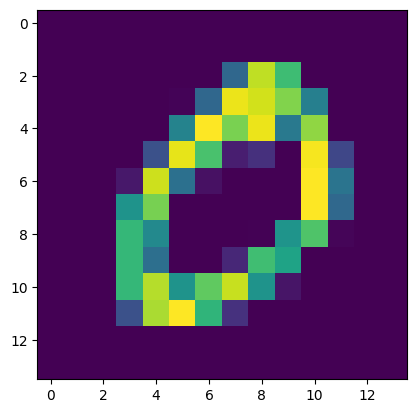

dict_keys([5, 6, 7, 8, 9])


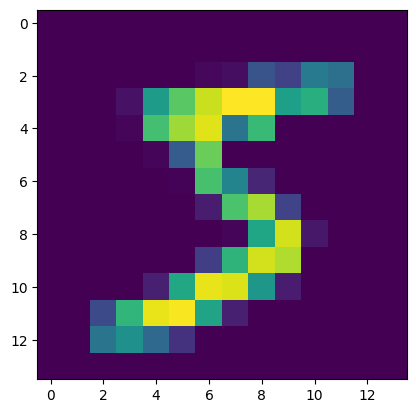

dict_keys([5, 6, 7, 8, 9])


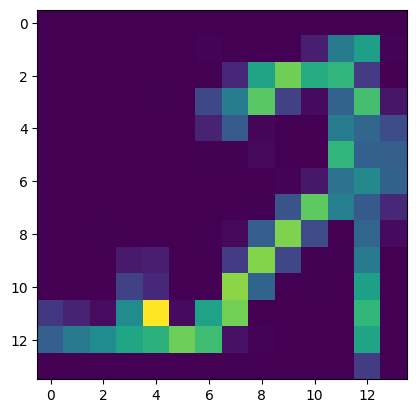

dict_keys([22, 23, 24, 25, 26])


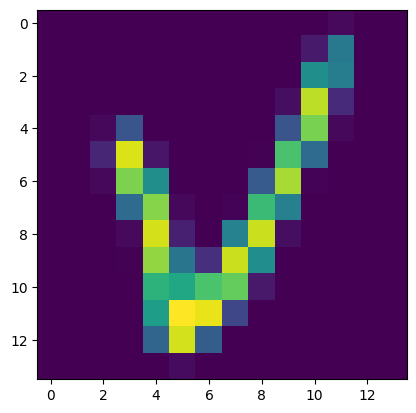

In [6]:
print(train[0].keys())
plt.imshow(train[0][list(train[0].keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(valid[0].keys())
plt.imshow(valid[0][list(valid[0].keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(mnist_test.keys())
plt.imshow(mnist_test[list(mnist_test.keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(fashion_test.keys())
plt.imshow(fashion_test[list(fashion_test.keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(emnist_test.keys())
plt.imshow(emnist_test[list(emnist_test.keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

In [7]:
BATCH_SIZE = 16
TIME = 1
DT = .25

n_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"


shape = [SIZE**2, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

# for i in range(shape[0]):
#     x = i % SIZE
#     y = i // SIZE

#     if x < SIZE-1:
#         connections.append((i, i+1))
#     if x > 0:
#         connections.append((i, i-1))
#     if y < SIZE-1:
#         connections.append((i, i+SIZE))
#     if y > 0:
#         connections.append((i, i-SIZE))

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

392


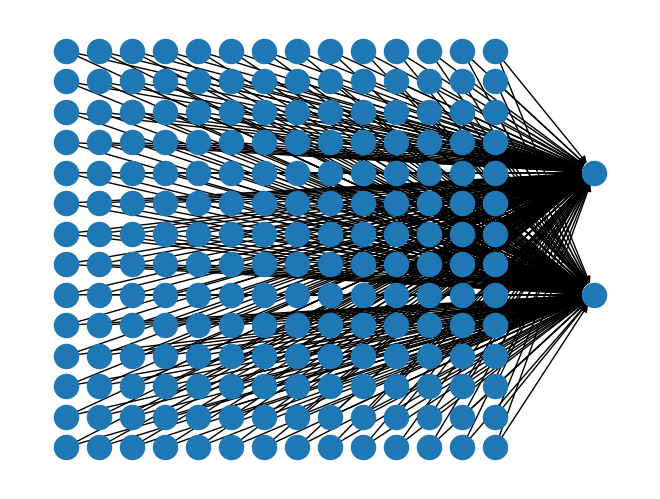

In [8]:
import networkx as nx

g = nx.DiGraph()
g.add_nodes_from(list(range(graph.n_nodes)))
g.add_edges_from(graph.connections)

pos = {i:np.array([i%SIZE, i//SIZE]) for i in range(SIZE**2)}

pos[SIZE**2] = np.array([SIZE+2, SIZE//2 - 2])
pos[SIZE**2 + 1] = np.array([SIZE+2, SIZE//2 + 2])

nx.draw(g, pos)

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

### Memorize Task
##### Repeat input/output pairs in order they're given

In [10]:
STEPS = 3_000
EXAMPLES = 10
log = []

In [11]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

100%|██████████| 3000/3000 [20:44<00:00,  2.41it/s, loss=0.000277, acc=1, overflow=3.27e-6]  


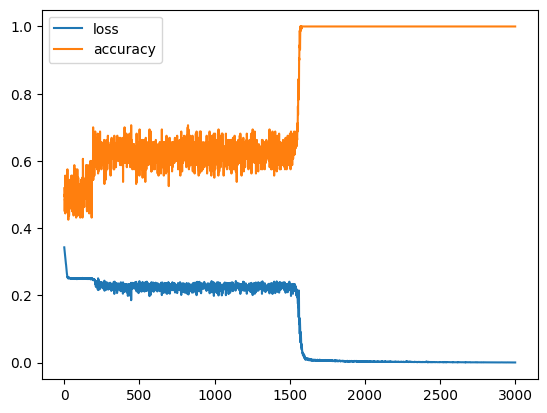

In [12]:
plt.plot([e['loss'] for e in log], label="loss")
# plt.ylim(0, .5)
# plt.show()

plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.show()

In [13]:
graph.save("models/direct_memorize.pt")

### Now train again with hidden layer

In [14]:
shape = [SIZE**2, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

1584


In [15]:
graph.load("models/direct_memorize.pt")

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

STEPS = 1_000
EXAMPLES = 10
log = []

In [17]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s, loss=0.00016, acc=1, overflow=0]          


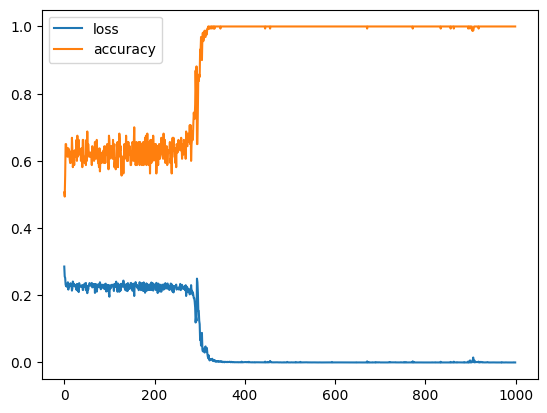

In [18]:
plt.plot([e['loss'] for e in log], label="loss")
# plt.ylim(0, .5)
# plt.show()

plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.show()

In [19]:
graph.save("models/memorize.pt")

### Generalization Task
##### Given input/output pairs from a specific task, given output from unseen input data from that task

In [20]:
graph.load("models/memorize.pt")

In [21]:
TRAIN_EXAMPLES = 10
TEST_EXAMPLES = 10
# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

STEPS = 10_000

log = []

In [22]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def get_batch_data(dataset=train, batch_size=BATCH_SIZE, train_examples=TRAIN_EXAMPLES, test_examples=TEST_EXAMPLES):
    if type(dataset) != list:
        dataset = [dataset]
    set_ = np.random.randint(len(dataset), size=(batch_size))

    classes = np.stack([np.random.choice(list(dataset[i].keys()), size=(n_classes), replace=False) for i in set_])
    
    # This gets completely random examples
    # y_train = np.random.randint(n_classes, size=(batch_size, train_examples))
    # y_test = np.random.randint(n_classes, size=(batch_size, TEST_EXAMPLES))

    # This gets balanced random examples
    
    y_train = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, train_examples)), axis=0), batch_size, axis=0).astype(np.int32)
    y_test = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, test_examples)), axis=0), batch_size, axis=0).astype(np.int32)

    y_train = shuffle_along_axis(y_train, axis=1)
    y_test = shuffle_along_axis(y_test, axis=1)


    x_train = []
    for batch_classes, y, i in zip(classes, y_train, set_):
        x_train.append([])
        for class_ in batch_classes[y]:
            x_train[-1].append(random.choice(dataset[i][class_]))
        x_train[-1] = np.stack(x_train[-1])
    x_train = np.stack(x_train)

    x_test = []
    for batch_classes, y, i in zip(classes, y_test, set_):
        x_test.append([])
        for class_ in batch_classes[y]:
            x_test[-1].append(random.choice(dataset[i][class_]))
        x_test[-1] = np.stack(x_test[-1])
    x_test = np.stack(x_test)
    
    return torch.Tensor(x_train).to(device), torch.Tensor(y_train).long().to(device), torch.Tensor(x_test).to(device), torch.Tensor(y_test).long().to(device), classes

In [23]:
bar = tqdm(range(1, STEPS+1))
for step in bar:

    # Train step
    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=train)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()


    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()


    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_test).float().mean()

    task_loss = criterion(pred, y_label)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    # Valid step
    with torch.no_grad():
        x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=valid)
        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        valid_acc = (pred.argmax(2) == y_test).float().mean()
        valid_loss = criterion(pred, y_label)

    # Save
    if step % 500 == 0 and step != 0:
        graph.save(f"models/generalize_{step}.pt")

    entry = {'valid_loss':valid_loss.item(), 'valid_acc':valid_acc.item(), 'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"valid_loss":np.mean([e["valid_loss"] for e in log[-10:]]), "valid_acc":np.mean([e["valid_acc"] for e in log[-10:]]), "loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

100%|██████████| 10000/10000 [1:41:32<00:00,  1.64it/s, valid_loss=0.0708, valid_acc=0.901, loss=0.088, acc=0.879, overflow=0.000129]


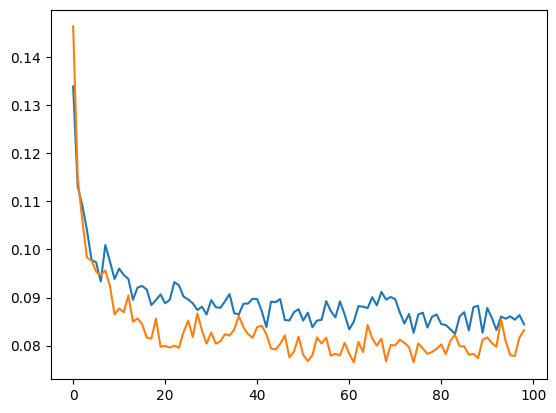

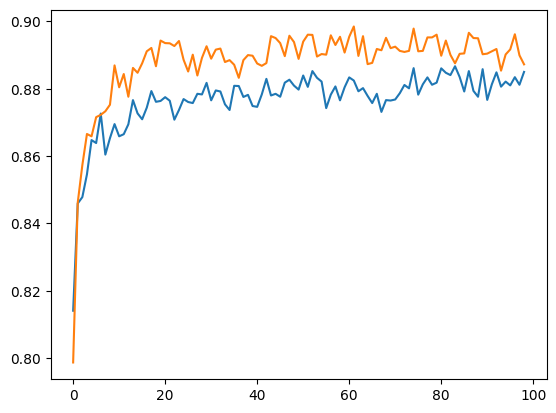

In [24]:
losses = [e["loss"] for e in log]
valid_losses = [e["valid_loss"] for e in log]

accs = [e["acc"] for e in log]
valid_accs = [e["valid_acc"] for e in log]

window = 100

plt.plot([np.mean(losses[i:i+window]) for i in range(0, len(losses)-window, window)])
plt.plot([np.mean(valid_losses[i:i+window]) for i in range(0, len(valid_losses)-window, window)])
plt.show()

plt.plot([np.mean(accs[i:i+window]) for i in range(0, len(accs)-window, window)])
plt.plot([np.mean(valid_accs[i:i+window]) for i in range(0, len(valid_accs)-window, window)])
plt.show()

### Evaluate on Train digits, Test digits, Fashion test

In [25]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(SIZE**2, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes),
            nn.Softmax(1),
        )
    
    def forward(self, x):
        return self.main(x)

def fit(model, x_train, y_train, steps=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    for e in range(steps):
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)

        loss.backward()
        optimizer.step()

In [26]:
overall_accs = {}
overall_losses = {}

N = 2048

for data_name, dataset in {"mnist_test":mnist_test, "emnist_test":emnist_test, "fashion_test":fashion_test}.items():# ["valid"]:
    print(f"Data: {data_name}")

    accs = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}
    losses = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        graph.init_vals(nodes=True, edges=True, batch_size=N)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        graph_acc = (pred.argmax(2) == y_test).float().mean()
        graph_loss = criterion(pred, y_label)

        accs["graph"].append(graph_acc.item())
        losses["graph"].append(graph_loss.item())

    # Try linear regression and an ANN on each batch
    for x_train_b, y_train_b, x_test_b, y_test_b, y_input_b, y_label_b in tqdm(zip(x_train, y_train, x_test, y_test, y_input, y_label), total=N):
        model = LinearRegression()

        model.fit(x_train_b.cpu(), y_input_b.cpu())
        pred = torch.Tensor(model.predict(x_test_b.cpu())).to(device)

        linreg_acc = (pred.argmax(1) == y_test_b).float().mean()
        linreg_loss = criterion(pred, y_label_b)

        accs["linreg"].append(linreg_acc.item())
        losses["linreg"].append(linreg_loss.item())


        # Train model for 1, 10, 50 epochs and record acc / loss
        for steps in [1, 10, 50]:
            model = Model().to(device)

            fit(model, x_train_b, y_input_b, steps=steps)
            pred = model(x_test_b)

            model_acc = (pred.argmax(1) == y_test_b).float().mean()
            model_loss = criterion(pred, y_label_b)

            accs[f"ANN_{steps}_steps"].append(model_acc.item())
            losses[f"ANN_{steps}_steps"].append(model_loss.item())

    overall_accs[data_name] = {k:np.mean(v) for k, v in accs.items()}
    overall_losses[data_name] = {k:np.mean(v) for k, v in losses.items()}

Data: mnist_test


100%|██████████| 2048/2048 [02:58<00:00, 11.45it/s]


Data: emnist_test


100%|██████████| 2048/2048 [02:56<00:00, 11.58it/s]


Data: fashion_test


100%|██████████| 2048/2048 [02:55<00:00, 11.69it/s]


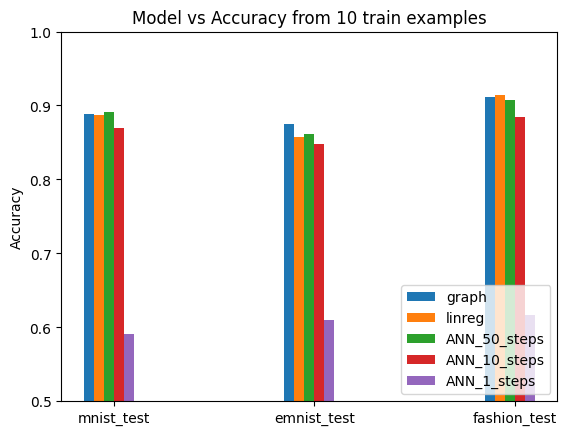

In [27]:
width=.05

plt.title("Model vs Accuracy from 10 train examples")

# plt.xticks(rotation='vertical')
plt.ylim(.5, 1)
plt.ylabel("Accuracy")

X = overall_accs.keys()
X_axis = np.arange(len(X))

plt.xticks(X_axis, X)

model_names = overall_accs[list(overall_accs.keys())[0]].keys()

for i, model_name in enumerate(model_names):
    accs = []
    for data_set in X:
        accs.append(overall_accs[data_set][model_name])
    plt.bar(X_axis + i*(width) - len(model_names)*(width/2), accs, width, label=model_name)
    

plt.legend(loc="lower right")
plt.savefig("results.png")
plt.show()

In [28]:
SIZE = 7

emnist = pd.read_csv("emnist-letters-train.csv").values

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist49 = split_dataset(x, y)

SIZE = 28

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist784 = split_dataset(x, y)

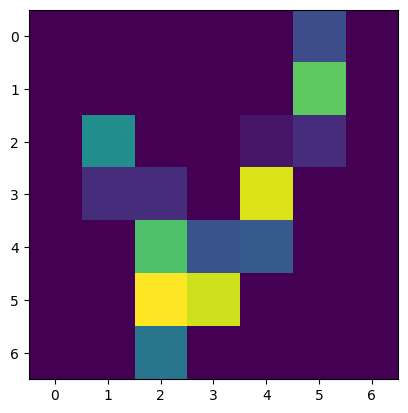

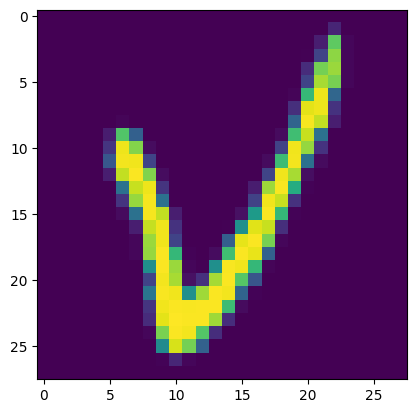

In [32]:
plt.imshow(emnist49[22][0].reshape(7, 7))
plt.show()
plt.imshow(emnist784[22][0].reshape(28, 28))
plt.show()

In [33]:
shape = [49, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph49 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph49.load("models/generalize_10000.pt")

shape = [784, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph784 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph784.load("models/generalize_10000.pt")

408
6288


In [47]:
N = 128

accs = {}
losses = {}

for data_name, dataset, g in zip(["emnist49", "emnist196", "emnist784"], [emnist49, emnist_test, emnist784], [graph49, graph, graph784]):
    print(f"Data: {data_name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[data_name] = acc.item()
        losses[data_name] = loss.item()

Data: emnist49
Data: emnist196
Data: emnist784


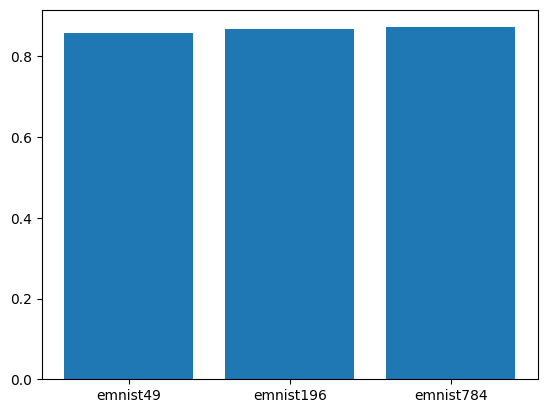

<BarContainer object of 3 artists>

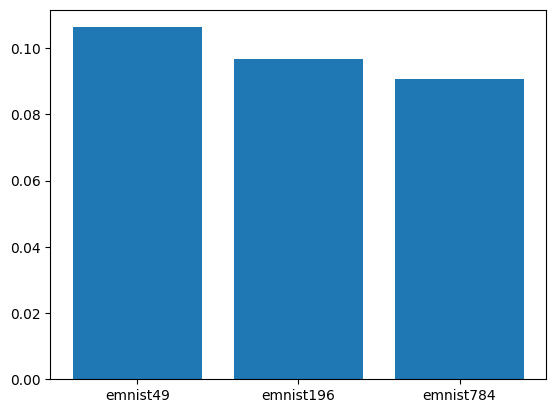

In [49]:
plt.bar(accs.keys(), accs.values())
plt.show()
plt.bar(losses.keys(), losses.values())

In [87]:
shape = [14**2, 4, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h4 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h4.load("models/generalize_10000.pt")

shape = [14**2, 16, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h16 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h16.load("models/generalize_10000.pt")

792
3168


In [88]:
accs = {}
losses = {}

for name, g in zip(["4 hidden", "8 hidden", "16 hidden"], [graph_h4, graph, graph_h16]):
    print(f"Data: {name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=emnist_test, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[name] = acc.item()
        losses[name] = loss.item()

Data: 4 hidden
Data: 8 hidden
Data: 16 hidden


In [89]:
print(accs)

{'4 hidden': 0.86328125, '8 hidden': 0.8765625357627869, '16 hidden': 0.8671875}


<BarContainer object of 3 artists>

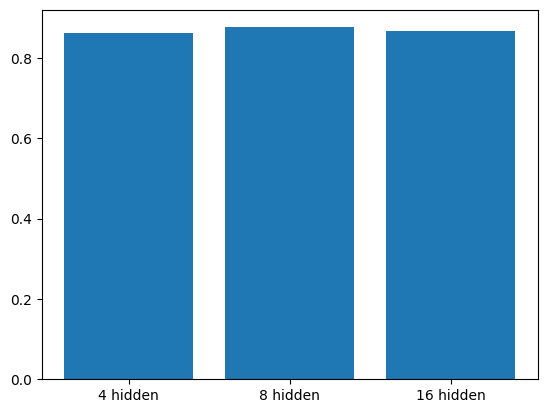

In [90]:
plt.bar(accs.keys(), accs.values())

In [92]:
shape = [14**2, 8, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_l2 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_l2.load("models/generalize_10000.pt")

1648


In [93]:
accs = {}
losses = {}

for name, g in zip(["1 layer", "2 layer"], [graph, graph_l2]):
    print(f"Data: {name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=emnist_test, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[name] = acc.item()
        losses[name] = loss.item()

Data: 1 layer
Data: 2 layer


In [94]:
print(accs)

{'1 layer': 0.882031261920929, '2 layer': 0.546093761920929}


<BarContainer object of 2 artists>

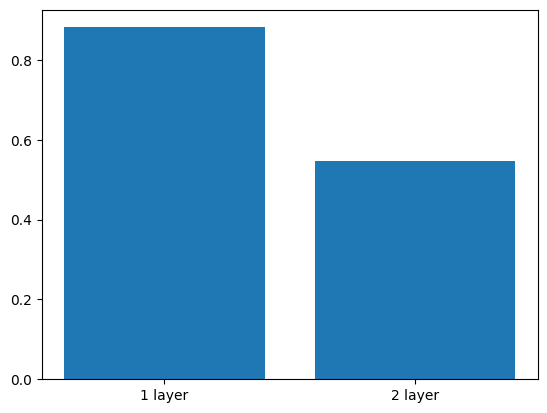

In [95]:
plt.bar(accs.keys(), accs.values())